<a href="https://colab.research.google.com/github/r6chow/IDC_Histopathology/blob/master/IDC_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ! pip install keras --upgrade
# ! pip install tensorflow --upgrade
!pip install annoy
#!pip install imbalanced-learn --upgrade

# Import libraries

In [3]:
import os
from google.colab import drive
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, models, optimizers, regularizers
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K


from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from tensorflow.keras.preprocessing.image import ImageDataGenerator




import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors

from annoy import AnnoyIndex #approximate nearest neighbour

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps

import itertools

import time
import datetime


import imblearn


#from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10195861784895723052
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5598753289149559324
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13857806833073452384
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4095569518769355779
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Functions

## Pad
This function will pad array with specified value to get the desired shape

In [5]:
def pad(array, shape, pad_value):
    """
    array: Array to be padded
    reference: Reference array with the desired shape
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    """
    # reference 
    result = np.full(shape, pad_value)
    # Create a list of slices from offset to offset + shape in each dimension
    
    if array.shape == result.shape:
      result = array
    else:
      insertHere = [slice(0, array.shape[dim]) for dim in range(array.ndim)]
      
      # Insert the array in the result at the specified offsets
      result[insertHere] = array
    
    return np.asarray(result)

## Show split
Show the distribution of data in Train, Validation and Test


In [6]:
def show_split(y_train, y_valid, y_test):

  total_rec = len(y_train) + len(y_valid) + len(y_test)
  print('Total count: {0}\n'.format(total_rec))
  #distribution of positive/negative cases in training, validation and test
  for tup in [('train', y_train), ('valid', y_valid), ('test',y_test)]:
      type_data =  tup[0]
      y_data = tup[1]

      num_rec = len(y_data)
      num_cancer = len([y for y in y_data if y[0] == 0])
      num_non_cancer = len([y for y in y_data if y[0] == 1])
      
      
      perc_rec = num_rec/total_rec
      
      perc_cancer = 0
      perc_non_cancer = 0
    
      if (num_rec > 0):
        perc_cancer =  num_cancer/num_rec
        perc_non_cancer = num_non_cancer/num_rec


      print('{0} count: {1} ({2:.5f})'.format(type_data, num_rec, perc_rec) )
      print('{0} cancer count: {1} ({2:.5f})'.format(type_data, num_cancer, perc_cancer))
      print('{0} non-cancer count: {1} ({2:.5f})\n'.format(type_data, num_non_cancer, perc_non_cancer) )
  

## Randomize pair of array


In [7]:
def randomize(a, b):

  indices = np.arange(len(a))
  np.random.seed(1)
  np.random.shuffle(indices)

  a = [a[idx] for idx in indices]
  b = [b[idx] for idx in indices]

  return a, b

## Custom batch generator

In [8]:
# reference:
# https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-2-be9ad08f3f0e

def image_label_generator(images, labels, batch_size=32, scale_factor=1, pad_flg=True, pad_size=(32,32,3), pad_value=255, image_data_generator = None):
    """
    Yields the next training batch.
    images is array of <pil Image>]
    labels is array of label.
    batch_size is the size of a batch
    scale is the scale to resize the image 
    """
    
    num_images = len(images)
    while True: # Loop forever so the generator never terminates
        
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_images, batch_size):
            #print('num_images:', num_images)
            
            #print('offset:', offset)
            # Get the images in batch
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            # Initialise X_batch and y_batch arrays for this batch
            X_batch = []
            y_batch = []

            # For each image in the batcn
            for i,batch_image in enumerate(batch_images):
                
                #print(batch_image)
                img = batch_image['img']

                #print(batch_image['file'])
                #scale images
                newWidth = max(1, (int(img.size[0] * scale_factor)))
                newHeight = max(1, (int(img.size[1] * scale_factor)))
                img = img.resize( (newWidth, newHeight) )

                # #gaussain blur  
                # rnd = np.random.random()
                # if rnd > 0.5:
                #   img = img.filter(ImageFilter.GaussianBlur)

                # #convert to RGB and standardize images to size pad_size (ie. (32,32,3) )
                # rgb_img = np.asarray(img)

                if pad_flg:
                  rgb_img = pad(np.asarray(img), pad_size, pad_value)

                # apply random image augmentation
                if (image_data_generator != None):
                  params = image_data_generator.get_random_transform(rgb_img.shape)
                  rgb_img = image_data_generator.apply_transform(rgb_img, params)
                  rgb_img = image_data_generator.standardize(rgb_img)
              
                
                rgb_img = rgb_img / 255

                X_batch.append(rgb_img)
                y_batch.append(batch_labels[i])

            # Make sure they're numpy arrays (as opposed to lists)    
            X_batch = np.asarray(X_batch)
            y_batch = np.asarray(y_batch)

            # The generator-y part: yield the next training batch            
            yield X_batch, y_batch





## Get batch generators

In [9]:
def get_genrators(X_train, X_valid, X_test, y_train, y_valid, y_test, batch_size=512, scale_factor=1, pad_flg=True, pad_size=(50,50), pad_value=255):

  train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  return train_image_label_generator, valid_image_label_generator, test_image_label_generator

## Plot performance

In [10]:
def plot_performance(hist, modelName = ''):
  fig, axes = plt.subplots(3, 1, figsize=(10,15))

  axes[0].plot(range(len(hist['accuracy'])), hist['accuracy'])
  axes[0].plot(range(len(hist['val_accuracy'])), hist['val_accuracy'])
  axes[0].legend(['Train', 'Validation'])
  axes[0].set_title('Accuracy vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')

  axes[1].plot(range(len(hist['loss'])), hist['loss'])
  axes[1].plot(range(len(hist['val_loss'])), hist['val_loss'])
  axes[1].legend(['Train', 'Validation'])
  axes[1].set_title('Loss vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')

  axes[2].plot(range(len(hist['auc'])), hist['auc'])
  axes[2].plot(range(len(hist['val_auc'])), hist['val_auc'])
  axes[2].legend(['Train', 'Validation'])
  axes[2].set_title('AUC vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[2].set_ylabel('AUC')
  axes[2].set_xlabel('Epoch')

  fig.tight_layout(pad=3.0)
  

## Plot confusion matrix

In [11]:
#reference:
#https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images 
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                      ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 4)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Generate Synthetic Image generation
Using the ANNOY (Approximate Nearest Neighbors Oh Yeah) library
reference: https://pypi.org/project/annoy/


In [12]:
#get N synthetic data from X (array of Images)

def convertToFlat(X, shape=(50,50,3)):
  X_flat = np.array([pad(np.asarray(x), shape,  255) for x in X])
  X_flat = X_flat.reshape(len(X_flat), shape[0] * shape[1] * shape[2])

  return X_flat 

#construct index
def buildAnnoyIndex(X, numTree=10):
  f = X.shape[1]
  t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
  for i in range(len(X)):
    v = X[i]
    t.add_item(i, v)
  
  t.build(numTree) # number of trees
  return t

def getNSynthetic_Annoy(X, N, num_neighbours=10, rand_state=1, annoyIndex = None, shape =(50,50,3)):

  startTime = time.time()
  if annoyIndex == None:
    X_flat = convertToFlat(X, shape)
    annoyIndex = buildAnnoyIndex(X_flat, 200) 

  endTime = time.time()
  print('0. Seconds to construct index for {0} points: {1}'.format(len(X), endTime - startTime))

  np.random.seed(rand_state)

  X_orig = []
  X_new = []
  X_nb = []
  X_idx = []


  startTime = time.time()
  for i in range(N):
    #get a random index
    X_idx.append(np.random.randint(0, len(X_flat)))

  endTime = time.time()
  print('1. Seconds to get {0} random indices: {1}'.format(N, endTime - startTime))

  #get neighbours of x_point
  indices = []
  startTime = time.time()
  for i in range(N):
    indices.append(annoyIndex.get_nns_by_item(X_idx[i], num_neighbours))
  endTime = time.time()
  print('2. Seconds to neighbours of random points: {0}'.format(endTime - startTime))


  startTime = time.time()

  for i, idx_lst in enumerate(indices):
    #random weight between 0 and 1
    u = np.random.random()
 
    #pick a random neighbour
    rand_nb_idx = idx_lst[np.random.randint(1, len(idx_lst))]
    x_nb =  X_flat[rand_nb_idx]
    x_point = X_flat[X_idx[i]]

    #new point
    x_gen = x_point + (u*(x_nb - x_point))
    x_gen = np.reshape(x_gen, shape)
    x_gen = Image.fromarray(x_gen.astype('uint8'), 'RGB') 

    x_point = np.reshape(x_point, shape)
    x_point = Image.fromarray(x_point.astype('uint8'), 'RGB') 

    x_nb = np.reshape(x_nb, shape)
    x_nb = Image.fromarray(x_nb.astype('uint8'), 'RGB') 

    X_orig.append(X[X_idx[i]])
    X_nb.append(x_nb)
    X_new.append(x_gen)


  endTime = time.time()
  print('3. Seconds to construct new point: {0}'.format(endTime - startTime))

  return X_orig, X_nb, X_new


def getNRandom(X, y, N, rand_state=42):
  startTime = time.time()

  np.random.seed(rand_state)

  X_idx = []
  X_new = []
  startTime = time.time()
  for i in range(N):
    #get a random index
    X_idx.append(np.random.randint(0, len(X)))

  X_new = [X[i] for i in X_idx]
  y_new = [y[i] for i in X_idx]

  return X_new, y_new


## View Slide


In [13]:

# Stitch patches that belong to one ID  
def viewSlide(images, id, scale=0.25, border_width=1, mark_cancer=True, img_attrib='img', patch_size=50):
  image_list = [img for img in images if img['id'] == id]

  min_x = min([img['x'] for img in image_list])
  max_x = max([img['x'] for img in image_list])
  min_y = min([img['y'] for img in image_list])
  max_y = max([img['y'] for img in image_list])

  total_width = (max_x - min_x + patch_size)
  total_height = (max_y - min_y + patch_size)

  new_img = Image.new('RGB', (total_width, total_height), color=(255,255,255))

  # for img in [i for i in image_list]: 
  #   new_img.paste(img['img'], (img['x'] - min_x ,img['y']-min_y))


  for img in image_list:
      baseImage = img[img_attrib]

      if mark_cancer:
        if img['class'] == '1':
          class_img = Image.new('RGB', baseImage.size, color=(0,255,0))
          mask = Image.new("L", baseImage.size, 180)
          im = Image.composite(baseImage, class_img, mask)
        else:
          class_img = Image.new('RGB', baseImage.size, color=(255,255,255))
          mask = Image.new("L", baseImage.size, 255)
          im = baseImage #Image.composite(baseImage, class_img, mask)
      else:
          im = baseImage
        
      bimg = ImageOps.expand(im, border=(border_width, border_width), fill=(0,0,0))
      
      new_img.paste(bimg, (img['x'] - min_x ,img['y']-min_y))


  return new_img.resize((int(total_width*scale), int(total_height*scale)))
  

## Cyclical Learning rate
Reference: https://github.com/bckenstler/CLR


In [14]:


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

## Custom Metrics

In [15]:

def recall_m(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
  
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def bac_m(y_true, y_pred):
    y_pred = np.argmax(y_pred,axis = 1) 
    y_true = np.argmax(y_true,axis = 1) 
    
    bac = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
    return bac


# Data Preparation

## Load list of image dictionary from pickled file on Google drive

In [16]:
#Mount Google drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#Load the picked file
binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
bin_file =  'IDC_regular_ps50_idx5_norm_macenko_13616.p'
images = pickle.load(open(binary_fldr + bin_file, 'rb'))


In [18]:
#check number if images, there hsould be 277,524
len(images)

277524

















## Shuffle the list of lmages

In [19]:
#Make a copy of image list before shuffling so we dont' have to load the picked.
#This is so we don't have to load the picked file again 
shuffledImages =  images.copy()

np.random.seed(931)
np.random.shuffle(shuffledImages)

In [20]:
# show first 3 records
shuffledImages[0:3]

[{'class': '0',
  'file': '9265_idx5_x2151_y2051_class0.png',
  'id': '9265',
  'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7FE9C7ADC668>,
  'x': 2151,
  'y': 2051},
 {'class': '1',
  'file': '9254_idx5_x2501_y1501_class1.png',
  'id': '9254',
  'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7FE9CDBBFB00>,
  'x': 2501,
  'y': 1501},
 {'class': '0',
  'file': '12947_idx5_x2451_y1101_class0.png',
  'id': '12947',
  'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7FE9D420A9B0>,
  'x': 2451,
  'y': 1101}]

## Get the image data (X) and labels (y)

In [21]:
n = len(images)
y = to_categorical([int(img['class']) for img in shuffledImages], num_classes = 2)[0:n]
y_label = [int(img['class']) for img in shuffledImages][0:n]


X = [img for img in shuffledImages][0:n]


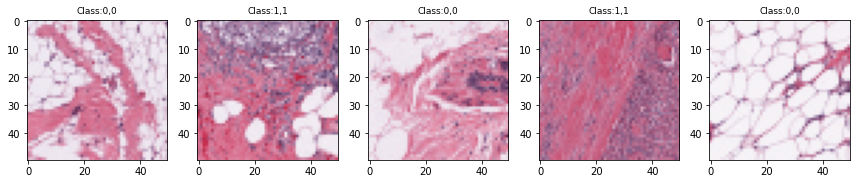

In [22]:

#visualize first few images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(5):
  axes[i].set_title('Class:{0},{1}'.format(str(np.argmax(y[i])), X[i]['class'] ), fontsize=9 )
  axes[i].imshow(X[i]['img'])

plt.tight_layout()

## Split Data in Train, Validation and Test

In [23]:
train_split = 0.7
valid_split = 0.5

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=1-train_split, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)



In [24]:
# #Split by IDs
# train_split = 0.8
# valid_split = 0.5

# ids = np.unique([img['id'] for img in images])
# np.random.seed(1)
# rand = np.random.rand(len(ids))

# id_train, id_valid_test, id_train, id_valid_test = train_test_split(ids, ids, test_size=1-train_split, random_state=42, shuffle=True)
# id_valid, id_test, id_valid, id_test = train_test_split(id_valid_test, id_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)

# idx_train = [idx for idx, x in enumerate(X) if x['id'] in id_train]
# idx_valid = [idx for idx, x in enumerate(X) if x['id'] in id_valid]
# idx_test = [idx for idx, x in enumerate(X) if x['id'] in id_test]

# X_train = [X[idx] for idx in idx_train]
# y_train = [y[idx] for idx in idx_train]


# X_valid = [X[idx] for idx in idx_valid]
# y_valid = [y[idx] for idx in idx_valid]


# X_test = [X[idx] for idx in idx_test]
# y_test = [y[idx] for idx in idx_test]




In [25]:
# ids

In [26]:
# id_train[0:10]

In [27]:
# id_valid[0:10]

In [28]:
# id_test[0:10]

In [29]:
#show the data counts
show_split(y_train, y_valid, y_test)

Total count: 277524

train count: 194266 (0.70000)
train cancer count: 55239 (0.28435)
train non-cancer count: 139027 (0.71565)

valid count: 41629 (0.15000)
valid cancer count: 11863 (0.28497)
valid non-cancer count: 29766 (0.71503)

test count: 41629 (0.15000)
test cancer count: 11684 (0.28067)
test non-cancer count: 29945 (0.71933)



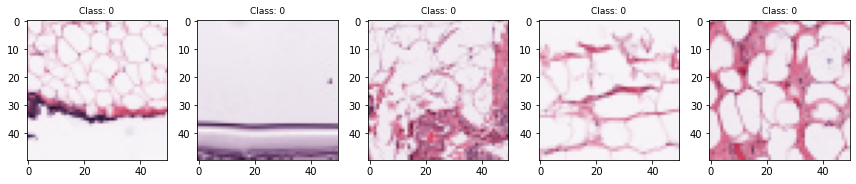

In [30]:
#visualize first few training images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(num_fig):
  axes[i].set_title('Class: ' + str(np.argmax(y_train[i])), fontsize=9 )
  axes[i].imshow(X_train[i]['img'])

plt.tight_layout()

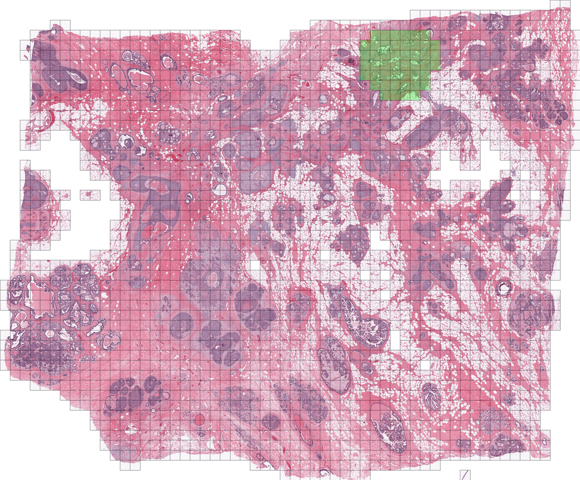

In [31]:
viewSlide(images, '10288', scale=0.2, mark_cancer=True)

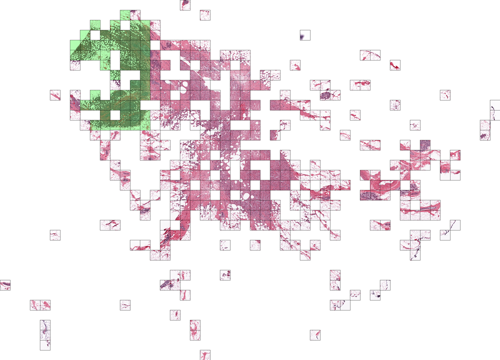

In [32]:
viewSlide(X_train, '10253', scale=0.2, mark_cancer=True)

# Balance the training

In [33]:
balanceType = 'None'

## Random Ovesampling
Reference: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


### Get all minority class images

In [34]:
blnLoad = False
shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'

if balanceType == 'RandomOver':
  if blnLoad:
    X_train = pickle.load(open(binary_fldr + 'X_train_over.p', 'rb'))
    y_train = pickle.load(open(binary_fldr + 'y_train_over.p', 'rb'))
  
  else:  
    X_minority = [X_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
    y_minority = [y_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
    num_maj = len([y for y in y_train if y[0] == 1])
    num_min = len([y for y in y_train if y[0] == 0])

    X_rdm, y_rdm = getNRandom(X_minority, y_minority, num_maj - num_min)

    X_train_org = X_train.copy()
    y_train_org = y_train.copy()

    X_train = X_train + X_rdm
    y_train = np.insert(y_train, len(y_train), y_rdm, axis=0)

    pickle.dump( X_train, open( shared_binary_fldr + 'X_train_over.p', "wb" ) )
    pickle.dump( y_train, open( shared_binary_fldr + 'y_train_over.p', "wb" ) )

### Generate synthetic oversampling minority class

In [35]:

blnGenerate = False

shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'

if balanceType == 'Smote':

  if blnGenerate:
    X_org, X_nb, X_gen = getNSynthetic_Annoy(X_minority, num_maj - num_min)

    pickle.dump( X_gen, open( shared_binary_fldr + 'X_gen_smote.p', "wb" ) )
    pickle.dump( X_org, open( shared_binary_fldr + 'X_org_smote.p', "wb" ) )
    pickle.dump( X_nb, open( shared_binary_fldr + 'X_nb_smote.p', "wb" ) )

  else:
    X_org = pickle.load(open(binary_fldr + 'X_org_smote.p', 'rb'))
    X_nb = pickle.load(open(binary_fldr + 'X_nb_smote.p', 'rb'))
    X_gen = pickle.load(open(binary_fldr + 'X_gen_smote.p', 'rb'))
    print('Load from binary') 

## Random Under sampling

In [36]:
blnLoad = False
shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'

if balanceType == 'RandomUnder':
  if blnLoad:
    X_train = pickle.load(open(binary_fldr + 'X_train_under.p', 'rb'))
    y_train = pickle.load(open(binary_fldr + 'y_train_under.p', 'rb'))
  
  else:  
    X_minority = [X_train[i] for i,y in enumerate(y_train) if y[0] == 0]
    y_minority = [y_train[i] for i,y in enumerate(y_train) if y[0] == 0]

    X_majority = [X_train[i] for i,y in enumerate(y_train) if y[0] == 1]
    y_majority = [y_train[i] for i,y in enumerate(y_train) if y[0] == 1]

    num_maj = len([y for y in y_train if y[0] == 1])
    num_min = len([y for y in y_train if y[0] == 0])

    X_rdm, y_rdm = getNRandom(X_majority, y_majority, num_min)

    X_train_org = X_train.copy()
    y_train_org = y_train.copy()

    X_train = X_minority + X_rdm
    y_train = np.insert(y_minority, len(y_minority), y_rdm, axis=0)

    pickle.dump( X_train, open( shared_binary_fldr + 'X_train_under.p', "wb" ) )
    pickle.dump( y_train, open( shared_binary_fldr + 'y_train_under.p', "wb" ) )

## Visualize synthetic image

In [39]:
# numImages = 10

# fig, axes = plt.subplots(numImages, 3, figsize=(12,20))

# idx_list = np.random.randint(0,len(X_gen),numImages)

# for i, idx in enumerate(idx_list):

#   axes[i][0].set_title('Original', fontsize=9 )
#   axes[i][0].imshow(X_org[idx])

#   axes[i][1].set_title('Neighbour', fontsize=9 )
#   axes[i][1].imshow(X_nb[idx])

#   axes[i][2].set_title('Generated', fontsize=9 )
#   axes[i][2].imshow(X_gen[idx])
  
# plt.tight_layout()

## Simple replication  
Take all the positive classes and generate additional images by flipping them horizontally and vertically


In [40]:
# #get the list of positive images
# pos_idx = [i for i in range(len(y_train)) if y_train[i][1] == 1]

# # make copies by fliping some top/bottom and some left/right
# for i in pos_idx:
#   x = X_train[i].copy()
  
#   if i % 2 == 0:
#     x = x.transpose(Image.FLIP_TOP_BOTTOM)
#   else :
#     x = x.transpose(Image.FLIP_LEFT_RIGHT)
  
  
#   X_train.append(x)
#   #y_train.append(y_train[i])
#   y_train = np.insert(y_train, len(y_train),  y_train[i], axis=0)

## Append and Save Training for re-use




In [41]:

# blnLoadTrainSmote = True

# shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
  
# if blnLoadTrainSmote:
#   X_train = pickle.load(open(binary_fldr + 'X_train_smote.p', 'rb'))
#   y_train = pickle.load(open(binary_fldr + 'y_train_smote.p', 'rb'))
# else:
#   X_train = X_train + X_gen

#   for i in range(len(X_gen)):
#     y_train = np.insert(y_train, len(y_train), y_minority[0], axis=0)

#   pickle.dump( X_train, open( shared_binary_fldr + 'X_train_smote.p', "wb" ) )
#   pickle.dump( y_train, open( shared_binary_fldr + 'y_train_smote.p', "wb" ) )



In [42]:
# reshuffle the data
X_train, y_train = randomize(X_train, y_train)


In [43]:
#show the data counts
show_split(y_train, y_valid, y_test)

Total count: 277524

train count: 194266 (0.70000)
train cancer count: 55239 (0.28435)
train non-cancer count: 139027 (0.71565)

valid count: 41629 (0.15000)
valid cancer count: 11863 (0.28497)
valid non-cancer count: 29766 (0.71503)

test count: 41629 (0.15000)
test cancer count: 11684 (0.28067)
test non-cancer count: 29945 (0.71933)



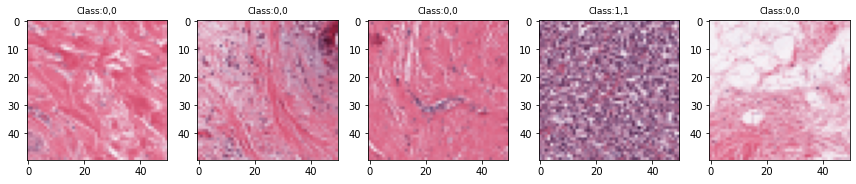

In [44]:
#visualize first few training images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(num_fig):
  axes[i].set_title('Class:{0},{1}'.format(str(np.argmax(y_train[i])), X_train[i]['class']), fontsize=9 )
  axes[i].imshow(X_train[i]['img'])

plt.tight_layout()

# Set up image generators

## Setup Image Data Generator for Data augmentation

In [45]:
dataGen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=0,
                             height_shift_range=0.0,
                             width_shift_range=0.0, 
                             shear_range=0,
                             fill_mode='constant',
                             cval=255,
                             )

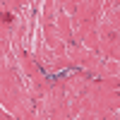

In [46]:
X_train[2]['img'].resize((120,120))

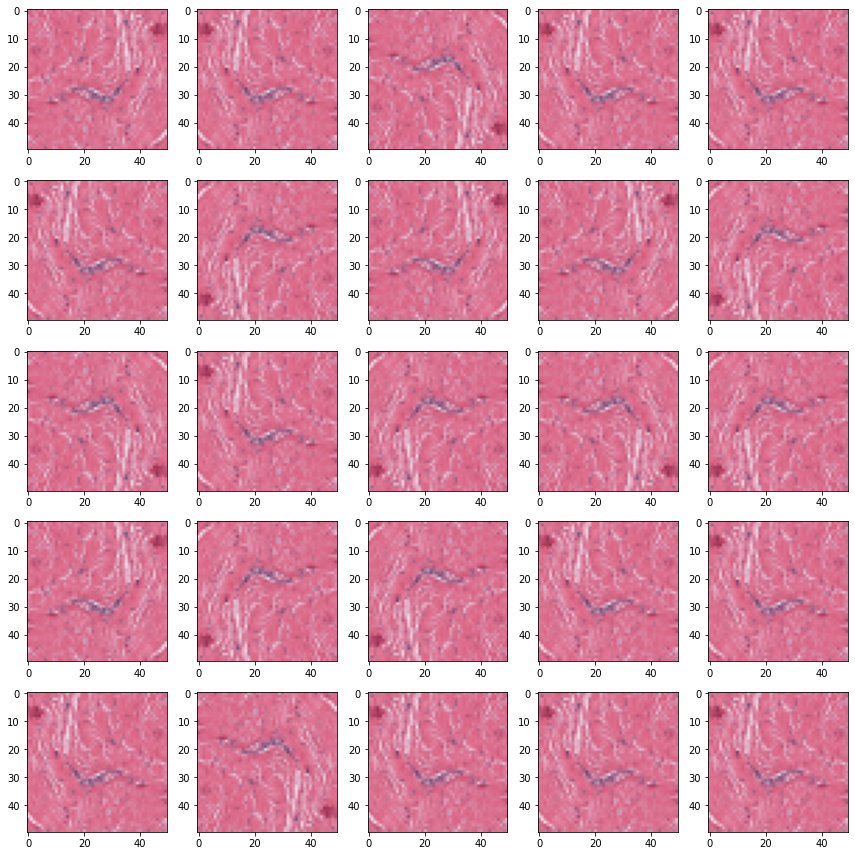

In [47]:
orig_rgb_img = pad(np.asarray(X_train[2]['img']), (50,50,3), 255)

num_fig = 5

fig, axes = plt.subplots(num_fig, num_fig, figsize=(12,12))

for i in range(25):
  
  col = i % num_fig
  row = int(i / num_fig) 

  params = dataGen.get_random_transform(orig_rgb_img.shape)
  rgb_img = dataGen.apply_transform(orig_rgb_img, params)
  rgb_img = dataGen.standardize(rgb_img)

  axes[row][col].imshow(Image.fromarray(rgb_img.astype('uint8'), 'RGB'))



plt.tight_layout()




## Use custom image generator

In [48]:

batch_size = 512
scale_factor = 50/50
pad_flg = True
pad_size = (50,50,3)
pad_value = 255

train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value, dataGen)
#train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value) #no data augmentation
valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

train_size = len(y_train)
valid_size = len(y_valid)
test_size = len(y_test)

train_steps = int(np.ceil(train_size/batch_size))
valid_steps = int(np.ceil(valid_size/batch_size))
test_steps = int(np.ceil(test_size/batch_size))


# Model


## Model 1 - Simple Architecuture

### Setup different architecture


Setting up simple Architecture 3 Convolution Layers with different number of filters.  The number of hidden units in the fully connected layers is equal to the number of filters


In [49]:
model_list = []

num_filters = [256]


for filters in num_filters:

  model = models.Sequential()
  model.add(layers.Conv2D(filters, (10,10), activation='relu', input_shape=(50,50,3),kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
  model.add(layers.Conv2D(filters, kernel_size=(5,5), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
  model.add(layers.Conv2D(filters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
  model.add(layers.Conv2D(filters, kernel_size=(2,2), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
  model.add(layers.Flatten())
  model.add(layers.Dense(filters, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

  model.summary()

  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(class_id = 0, name='recall_0', thresholds=0.5), tf.keras.metrics.Recall(class_id = 1, name='recall_1')])
  
  model_list.append({'model':model, 'description': 'filters=' + str(filters)})

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 41, 256)       77056     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         2


### Training

Training with 50 epoch with early stopping on each model

In [50]:
hist_list = []

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10,  verbose=True, restore_best_weights=True)
clr_triangular = CyclicLR(mode='triangular2', base_lr=1e-4, max_lr=9e-4, step_size=int(train_steps*3))

for m in model_list:
  print('training model:{0}'.format(m['description']))
  hist =  m['model'].fit(x=train_image_label_generator, epochs=50,  steps_per_epoch = train_steps, callbacks=[earlystop_callback, clr_triangular],
                  validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)

  m['hist'] = hist.history



training model:filters=256
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
380/380 [==============================] - 52s 137ms/step - loss: 0.9063 - accuracy: 0.7728 - auc: 0.8503 - recall_0: 0.9318 - recall_1: 0.3728 - val_loss: 0.5555 - val_accuracy: 0.8264 - val_auc: 0.9010 - val_recall_0: 0.9122 - val_recall_1: 0.6112
Epoch 2/50
380/380 [==============================] - 51s 134ms/step - loss: 0.5550 - accuracy: 0.7982 - auc: 0.8707 - recall_0: 0.9175 - recall_1: 0.4981 - val_loss: 0.4597 - val_accuracy: 0.8296 - val_auc: 0.9046 - val_recall_0: 0.9078 - val_recall_1: 0.6333
Epoch 3/50
380/380 [==============================] - 51s 134ms/step - loss: 0.5011 - accuracy: 0.8001 - auc: 0.8721 - recall_0: 0.9196 - recall_1: 0.4992 - val_loss: 0.4572 - val_accuracy: 0.8331 - val_auc: 0.9019 - val_recall_0: 0.9016 - val_recall_1: 0.6613
Epoch 4/50
380/380 [==============================] - 51s 134ms/step - loss: 0.4360 - accuracy: 0.8276 - auc: 0.8977 - recall_0: 0.9077 - recall_1:


### Evaluation

In [51]:

for m in model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


{'description': 'filters=256',
 'hist': {'accuracy': [0.7728269696235657,
   0.7982457280158997,
   0.8000525236129761,
   0.8276280760765076,
   0.8357458114624023,
   0.8394520878791809,
   0.8408728241920471,
   0.8409088850021362,
   0.8411044478416443,
   0.842725932598114,
   0.8437812328338623,
   0.8459689021110535,
   0.8469727039337158,
   0.8465866446495056,
   0.8456652164459229,
   0.8459534645080566,
   0.8474050760269165,
   0.8483780026435852,
   0.8487331867218018,
   0.8485787510871887,
   0.8481772541999817,
   0.8486456871032715,
   0.8485890626907349,
   0.849067747592926,
   0.8493508696556091,
   0.8493560552597046,
   0.8491707444190979,
   0.8492530584335327,
   0.8495413661003113,
   0.8497729897499084,
   0.8502465486526489,
   0.8499943614006042,
   0.8503495454788208,
   0.8500921130180359,
   0.8504112958908081,
   0.8508694171905518,
   0.8505245447158813,
   0.8506944179534912,
   0.8505657315254211,
   0.8508488535881042,
   0.8507047295570374,
   0.850

### Performance curves

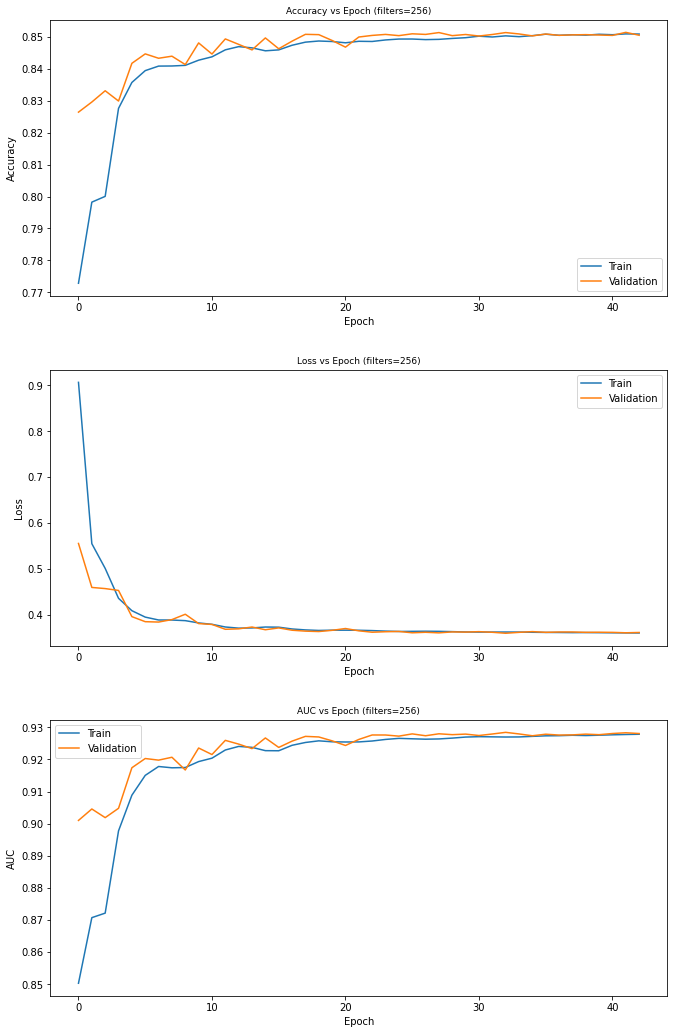

In [52]:
for m in model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix and Balanced Accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


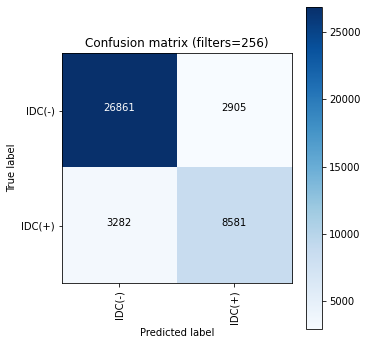

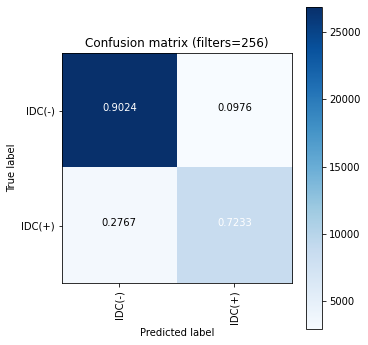

In [53]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in model_list:
  # test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  # y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)
  

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_valid,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))


In [54]:
y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)
y_pred[0:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


array([[0.75792545, 0.2420746 ],
       [0.98527837, 0.01472156],
       [0.67728823, 0.32271177],
       [0.79716074, 0.20283924],
       [0.86966383, 0.13033617],
       [0.9782357 , 0.0217643 ],
       [0.9751868 , 0.02481312],
       [0.12007499, 0.87992495],
       [0.8781852 , 0.12181477],
       [0.7230801 , 0.27691987]], dtype=float32)

### Compare Models orderd by BAC

In [55]:
# Comparison of all models

modelName = [m['description'] for m in model_list ]
modelBAC = [m['balanced_acc'] for m in model_list ]
modelLoss = [m['score'][0] for m in model_list ]
modelAccuracy = [m['score'][1] for m in model_list ]
modelAUC = [m['score'][2] for m in model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
0,filters=256,0.812873,0.851858,0.361269


Increasing the number of trainable parameters did not significanty import the accuracy of the model

## Model 2 - DenseNet Architectures



### Setup and training

In [56]:
blnTrainDense = True

tf_model_list = []

input_shape = (50, 50, 3)


modelDenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
modelResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

#modelInceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

baseModels = [
              # {'name':'DenseNet121_norm', 'model':modelDenseNet121, 'input_shape':input_shape},             
              # {'name':'DenseNet169_norm5', 'model':modelDenseNet169, 'input_shape':input_shape},
              {'name':'DenseNet201_norm3', 'model':modelDenseNet201, 'input_shape':input_shape}
              # {'name':'ResNet50_norm', 'model':modelResNet50, 'input_shape':input_shape}
              #{'name':'InceptionResNetv2_norm', 'model':modelInceptionResNetV2, 'input_shape':input_shape}
              ] 


shared_model_fldr = '/content/drive/Shared drives/Roger Chow/Model/'

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15,  verbose=True, restore_best_weights=True)
clr_triangular = CyclicLR(mode='triangular2', base_lr=5e-4, max_lr=5e-3, step_size=int(train_steps*3))

for baseModel in baseModels:

  print('base:' + baseModel['name'])

  if blnTrainDense:

    model = Sequential([baseModel['model'],  
                        layers.Flatten(),
                        layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
                        
                        ])

    # only train last layer
    for layer in model.layers[:-1]:
      layer.trainable = False

    #optimizer
    #sgd = optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
    adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)



    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=["accuracy", "AUC",tf.keras.metrics.Recall(class_id = 0, name='recall_0', thresholds=0.5), tf.keras.metrics.Recall(class_id = 1, name='recall_1')])
    model.summary()

    #train model
    hist =  model.fit(x=train_image_label_generator, epochs=50,  steps_per_epoch = train_steps, callbacks=[earlystop_callback, clr_triangular],
                    validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)
    
    #store the model and history
    tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':hist.history})

    #save model
    model.save(shared_model_fldr + baseModel['name'])

    #save hist
    pickle.dump( hist.history, open( shared_model_fldr + baseModel['name'] + '_hist.p', "wb" ) )
  
  else:

    model = tf.keras.models.load_model(shared_model_fldr + baseModel['name'])
  
    history = pickle.load(open(shared_model_fldr + baseModel['name'] + '_hist.p', 'rb'))

    tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':history})
 

base:DenseNet201_norm3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3842      
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


380/380 [==============================] - 45s 119ms/step - loss: 0.4307 - accuracy: 0.8138 - auc: 0.8865 - recall_0: 0.9246 - recall_1: 0.5348 - val_loss: 0.3915 - val_accuracy: 0.8336 - val_auc: 0.9065 - val_recall_0: 0.9320 - val_recall_1: 0.5865
Epoch 2/50
380/380 [==============================] - 40s 107ms/step - loss: 0.3913 - accuracy: 0.8351 - auc: 0.9072 - recall_0: 0.9170 - recall_1: 0.6291 - val_loss: 0.3881 - val_accuracy: 0.8370 - val_auc: 0.9093 - val_recall_0: 0.9345 - val_recall_1: 0.5923
Epoch 3/50
380/380 [==============================] - 40s 106ms/step - loss: 0.3917 - accuracy: 0.8348 - auc: 0.9076 - recall_0: 0.9157 - recall_1: 0.6313 - val_loss: 0.3888 - val_accuracy: 0.8355 - val_auc: 0.9093 - val_recall_0: 0.9099 - val_recall_1: 0.6487
Epoch 4/50
380/380 [==============================] - 40s 107ms/step - loss: 0.3909 - accuracy: 0.8359 - auc: 0.9083 - recall_0: 0.9155 - recall_1: 0.6355 - val_loss: 0.3869 - val_accuracy: 0.8371 - val_auc: 0.9103 - val_recall_

### Evaulation


In [57]:
for m in tf_model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [58]:
scores

[0.3804447054862976,
 0.8400874137878418,
 0.9129160046577454,
 0.9231925010681152,
 0.6270968914031982]

### Performance curves


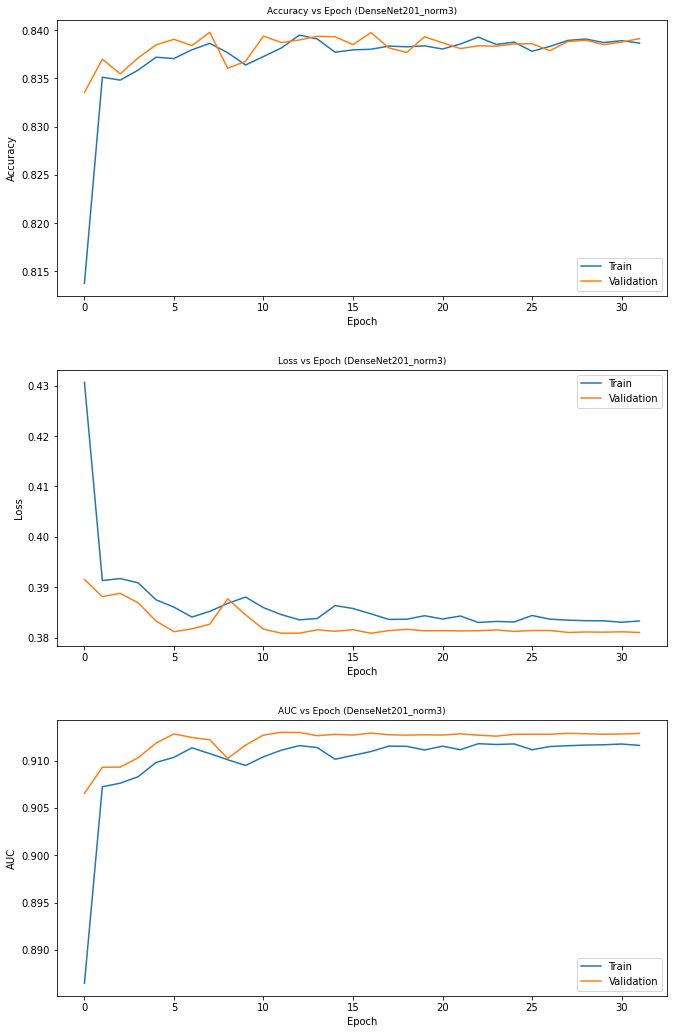

In [59]:
for m in tf_model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


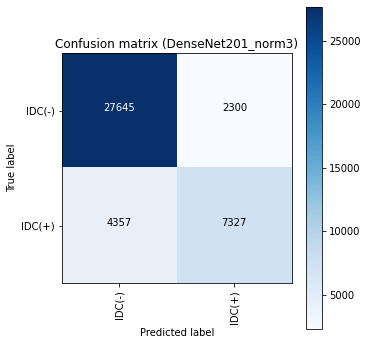

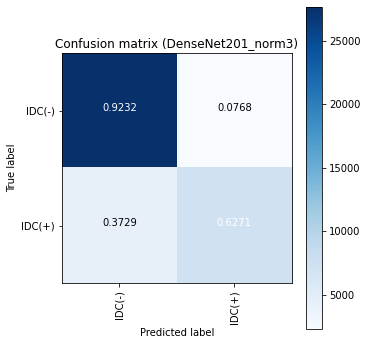

In [60]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)


### Compare Models order by BAC

In [61]:
modelName = [m['description'] for m in tf_model_list ]
modelBAC = [m['balanced_acc'] for m in tf_model_list ]
modelLoss = [m['score'][0] for m in tf_model_list ]
modelAccuracy = [m['score'][1] for m in tf_model_list ]
modelAUC = [m['score'][2] for m in tf_model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
0,DenseNet201_norm3,0.775145,0.840087,0.380445


In [62]:
len(y_pred)

41629

### Look at ones wrongly predicted from Validation


In [ ]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_valid,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)

In [ ]:
idx_fp = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i] and y_pred[i] == 1]
idx_fn = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i] and y_pred[i] == 0]

idx_tp = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i] and y_pred[i] == 1]
idx_tn = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i] and y_pred[i] == 0]



In [ ]:
#add a attribute for predicted class
for i in range(len(X_valid)):
  X_valid[i]['pred_class'] =  y_pred[i]



In [ ]:

def viewImages(X, idx, num_fig=5):
  num_fig = num_fig

  fig, axes = plt.subplots(num_fig, num_fig, figsize=(num_fig*2,num_fig*2))

  for i in range(num_fig*num_fig):
    
    col = i % num_fig
    row = int(i / num_fig) 

    img = X[idx[i]]['img']
    axes[row][col].set_title(X[idx[i]]['file'], fontsize=7 )
    axes[row][col].imshow(img)
    axes[row][col].axis('off')

  plt.tight_layout()

In [ ]:
#false positive
viewImages(X_valid, idx_fp, 10)

In [ ]:
#false negative
viewImages(X_valid, idx_fn, 10)

In [ ]:
#true positive
viewImages(X_valid, idx_tp, 10)

In [ ]:
#true negative
viewImages(X_valid, idx_tn, 10)

In [ ]:
def viewPrediction(id, scale = 0.25, X=X_valid, images=images):
  border_width = 4

  a_list = [img for img in images if img['id'] == id] 
  x_list = [img for img in X if img['id'] == id] 

  min_x = min([img['x'] for img in a_list])
  max_x = max([img['x'] for img in a_list])
  min_y = min([img['y'] for img in a_list])
  max_y = max([img['y'] for img in a_list])

  patch_size = 50

  total_width = (max_x - min_x + 50)
  total_height = (max_y - min_y + 50)

  new_im = Image.new('RGB', (total_width, total_height), color=(255, 255, 255))


  for img in a_list:
    base_img = img['img']
    if img['class'] == '1':
      class_img = Image.new('RGB', base_img.size, color=(0,255,0))
      mask = Image.new("L", base_img.size, 200)
      im = Image.composite(base_img, class_img, mask)
    else:
      class_img = Image.new('RGB', base_img.size, color=(255,255,255))
      mask = Image.new("L", base_img.size, 255)
      im = base_img #Image.composite(img['img'], class_img, mask)

    bimg =  ImageOps.crop(im, border=border_width)
    bimg = ImageOps.expand(bimg, border=(border_width, border_width), fill=(180,180,180))
    
    new_im.paste(bimg, (img['x'] - min_x ,img['y']-min_y))


  for img in a_list:

    if img['class'] == '1':
      class_img = Image.new('RGB', img['img'].size, color=(0,255,0))
      mask = Image.new("L", img['img'].size, 180)
      im = Image.composite(img['img'], class_img, mask)
    else:
      class_img = Image.new('RGB', img['img'].size, color=(255,255,255))
      mask = Image.new("L", img['img'].size, 255)
      im = Image.composite(img['img'], class_img, mask)

    
    #get the validation obj
    val_obj = [x for x in x_list if x['file'] == img['file']]
    if len(val_obj) > 0:
      val_obj = val_obj[0]
      
      bimg =  ImageOps.crop(im, border=border_width)
      if str(val_obj['pred_class']) == img['class']:
        bimg = ImageOps.expand(bimg, border=(border_width-1, border_width-1), fill=(0,255,0))
        
      elif str(val_obj['pred_class']) != img['class']:   #validation prediction incorrect
        bimg = ImageOps.expand(bimg, border=(border_width-1, border_width-1), fill=(255,0,0))  

      
      new_im.paste(bimg, (img['x'] - min_x ,img['y']-min_y))

  return new_im.resize((int(total_width*scale), int(total_height*scale))) 

In [ ]:
viewSlide(X_valid, '9323')

In [ ]:
viewPrediction('9323')

In [ ]:
ids = np.unique([img['id'] for img in images])

In [ ]:
for id in ids[0:10]:
  plt.figure(figsize=(20,20))
  plt.imshow(viewPrediction(id))
  plt.title(id)
  

# Cross Validation (TO DO)
reference: https://machinelearningmastery.com/k-fold-cross-validation/

Cross validation is used to estimate the perfomance of a model on unseen data to give confidence that a final model trained on ALL data will be valid.

All models trained in cross validation are discarded.  Only the evaluation score is retained for summary

## Setup stratifed K-Folds
reference: https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/



In [ ]:
#model 1
def simple_seq_model(numFilters): 
  model = models.Sequential()
  model.add(layers.Conv2D(numFilters, (3,3), activation='relu', input_shape=(50,50,3),kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(numFilters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(numFilters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(numFilters, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

  model.summary()

  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy', 'AUC'])

  return model


In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)


In [ ]:
simple_seq_model(128)

## Execute Cross Validation

In [ ]:
132492 - 52524

In [ ]:
batch_size = 512
scale_factor = 50/50
pad_flg = True
pad_size = (50,50,3)
pad_value = 255

num_epoch = 25


fold_idx = 0
fold_model_list = []


# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X, y_label):
  X_train = [X[i] for i in train_ix ]
  X_valid_test = [X[i] for i in test_ix ]
  
  y_train = [y[i] for i in train_ix ]
  y_valid_test = [y[i] for i in test_ix ]
  
  X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)

  print('fold {0}'.format(fold_idx)) 
  print ('num train: {0} ({1})  num test:{2} ({3})'.format(len(X_train), len(X_train)/len(X),len(X_test),len(X_test)/len(X)))
  
  #balance the training set 

  # ## get the list of positive images
  # pos_idx = [i for i in range(len(y_train)) if y_train[i][1] == 1]

  # ## make copies by fliping some top/bottom and some left/right
  # for i in pos_idx:
  #   x = X_train[i].copy()
    
  #   if i % 2 == 0:
  #     x = x.transpose(Image.FLIP_TOP_BOTTOM)
  #   else :
  #     x = x.transpose(Image.FLIP_LEFT_RIGHT)
    
    
  #   X_train.append(x)
  #   y_train = np.insert(y_train, len(y_train),  y_train[i], axis=0)

  #show split
  show_split(y_train, y_valid, y_test)
  
  # #set up generators
  # train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  # valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  # test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  # train_size = len(y_train)
  # valid_size = len(y_valid)
  # test_size = len(y_test)

  # train_steps = int(np.ceil(train_size/batch_size))
  # valid_steps = int(np.ceil(valid_size/batch_size))
  # test_steps = int(np.ceil(test_size/batch_size))
  

  # # simple model
  # mdl = simple_seq_model(128)

  # #train
  # hist =  mdl.fit(x=train_image_label_generator, epochs=num_epoch,  steps_per_epoch = train_steps, 
  #                 validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)


  # fold_model_list.append({"model": mdl, 'description': 'fold={0}'.format(fold_idx), 'hist': hist, 'X_test':X_test, 'y_test':y_test})
  
  # # #TO DO -- Plot performance
  # # plot_performance(hist, 'fold# {0}  filters={1}'.format(fold_idx, 128))

  # # #evaluate
  # # scores =  mdl.evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  
  # # cross_scores.append(scores)
  print()
  fold_idx += 1

  


## Evaulation


In [ ]:
for m in fold_model_list:

  X_test = m['X_test']
  y_test = m['y_test']

  test_size = len(y_test)
  test_steps = int(np.ceil(test_size/batch_size))

  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  
  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

## Performance curves


In [ ]:
for m in fold_model_list:
  plot_performance(m['hist'], m['description'])

## Confusion Matrix

In [ ]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in fold_model_list:
  X_test = m['X_test']
  y_test = m['y_test']

  test_size = len(y_test)
  test_steps = int(np.ceil(test_size/batch_size))

  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))



## Compare Folds order by BAC, Accuracy, Loss

In [ ]:
modelName = [m['description'] for m in fold_model_list ]
modelBAC = [m['balanced_acc'] for m in fold_model_list ]
modelLoss = [m['score'][0] for m in fold_model_list ]
modelAccuracy = [m['score'][1] for m in fold_model_list ]
modelAUC = [m['score'][2] for m in fold_model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
axes[0].set_title('Balanced Accuracy')
axes[0].boxplot(df.bac)

axes[1].set_title('Accuracy')
axes[1].boxplot(df.accuracy)

axes[2].set_title('Loss')
axes[2].boxplot(df.loss)


In [ ]:
df.mean()